<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/00-03-consolidaci%C3%B3n_train_test_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO: Consolidación del dataset
__Título:__ Etiquetado semi-supervisado multiclase de correos electrónicos a partir de estrategias de extracción de características y _Elasticsearch_

__Autores:__ Juan Manuel Fernandez, Marcelo Errecalde


En esta notebook se consolidan las clases de los correos que forman parte del trabajo dado que se encontraron clases solapadas y ejemplos mal clasificados:

## 0. Misceláneos:

### Descarga de librerias necesarias

In [1]:
!pip install requests
!pip install wget

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df, get_clases

### Descarga dataset de train y test

Se descargan los datasets con 800 correos en el caso de train y 200 correos para el de test:

In [3]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-train-80.csv

if not (path.exists('correos-test-20.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-test-20.csv

## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [4]:
import pandas as pd

# Cargo correos en un dataframe
correos_train = pd.read_csv('correos-train-80.csv')
correos_test = pd.read_csv('correos-test-20.csv')

## 2. Representación de las clases

Pasan a representarse las clases a partir de la etiqueta y no del valor numérico discretizado:


### 2.1 Transformación de las clases identificadas por el experto

In [5]:
from sklearn.preprocessing import LabelEncoder

clases = get_clases()

# Instancio el transformador
le = LabelEncoder()

# Discretizo
clases_disc = le.fit_transform(clases)

# Muestro clases originales
print(f'Clases originales:\n{clases}\n')

# Muestro clases discretizadas
print(f'Clases discretizadas:\n{clases_disc}\n')

# Accedo a la clase original por su valor discretizado
print(f'Acceso a la original, de id {2} con discretizada: {clases[clases_disc[2]]}')

Clases originales:
['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Carga de Notas' 'Certificados Web' 'Consulta por Equivalencias'
 'Consulta por Legajo' 'Consulta sobre Título Universitario' 'Cursadas'
 'Datos Personales' 'Exámenes' 'Ingreso a la Universidad'
 'Inscripción a Cursadas' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica' 'Vacunas Enfermería']

Clases discretizadas:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Acceso a la original, de id 2 con discretizada: Cambio de Comisión


### 2.2 Creación de un dataframe con las clases originales sin discretizar

In [6]:
# Aplico una transformacion inversa para des-discretizar
correos_train['clase'] = le.inverse_transform(correos_train['clase'])
correos_test['clase'] = le.inverse_transform(correos_test['clase'])

total_etiquetados = pd.concat([correos_train, correos_test])

# Muestro las primeras 5 clases originales
correos_train['clase'].head()
correos_test['clase'].head()

0        Boleto Universitario
1       Requisitos de Ingreso
2            Datos Personales
3    Ingreso a la Universidad
4             Reincorporación
Name: clase, dtype: object

## 3. Reorganización de las clases

A partir de falencias en el etiquetado encontradas en la construcción del modelo, se mejora el etiquetado en dos aspectos:
1. Se reorganizan las clases,
2. Se re-etiquetan algunas instancias

Además, se guardarán los correos con las clases sin discretizar (etiquetas textuales).


### 3.1 Reorganización de las clases

En este aspecto, se realizan los siguientes cambios:
- La clase 'Vacunas Enfermería' se unifica con 'Reguisitos de Ingreso'.
- La clase 'Inscripción a Cursadas' se unifica con 'Cursadas'.
- La clase 'Certificados Web' se unifica con 'Pedido de Certificados' que a su vez pasa a llamarse 'Emisión de Certificados'.
- La clase 'Carga de Notas' se unifica con 'Situación Académica'.

In [7]:
correos_train['clase'] = correos_train['clase'].replace(['Vacunas Enfermería'], 'Requisitos de Ingreso')
correos_test['clase'] = correos_test['clase'].replace(['Vacunas Enfermería'], 'Requisitos de Ingreso')

In [8]:
correos_train['clase'] = correos_train['clase'].replace(['Inscripción a Cursadas'], 'Cursadas')
correos_test['clase'] = correos_test['clase'].replace(['Inscripción a Cursadas'], 'Cursadas')

In [9]:
correos_train['clase'] = correos_train['clase'].replace(['Certificados Web'], 'Pedido de Certificados')
correos_test['clase'] = correos_test['clase'].replace(['Certificados Web'], 'Pedido de Certificados')

In [10]:
correos_train['clase'] = correos_train['clase'].replace(['Carga de Notas'], 'Situación Académica')
correos_test['clase'] = correos_test['clase'].replace(['Carga de Notas'], 'Situación Académica')

In [11]:
import numpy as np

np.sort(correos_train['clase'].unique())

array(['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
       'Consulta por Equivalencias', 'Consulta por Legajo',
       'Consulta sobre Título Universitario', 'Cursadas',
       'Datos Personales', 'Exámenes', 'Ingreso a la Universidad',
       'Pedido de Certificados', 'Problemas con la Clave',
       'Reincorporación', 'Requisitos de Ingreso',
       'Simultaneidad de Carreras', 'Situación Académica'], dtype=object)

In [12]:
np.sort(correos_test['clase'].unique())

array(['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
       'Consulta por Equivalencias', 'Consulta por Legajo',
       'Consulta sobre Título Universitario', 'Cursadas',
       'Datos Personales', 'Exámenes', 'Ingreso a la Universidad',
       'Pedido de Certificados', 'Problemas con la Clave',
       'Reincorporación', 'Requisitos de Ingreso',
       'Simultaneidad de Carreras', 'Situación Académica'], dtype=object)

### 3.2 Re-etiquetado de Instancias

En este aspecto, se vuelven a etiquetar instancias que estaban mal etiquetadas.

En primer lugar se des-setea el ancho de la columna para poder visualizar todo el texto de las consultas:


In [13]:
pd.set_option('display.max_colwidth', None)

El proceso consiste en visualizar el texto de las instancias para asegurarnos del reemplazo correcto con el siguiente código: <br />
`correos_test.loc[[2]][['Consulta', 'clase']]` <br />
Y luego el reemplazo con el método `at`: <br />
`correos_test.at[2, 'clase'] = 'Reincorporación'`

### 3.2.1 Re-etiquetado de Instancias

Comienza el re-etiquetado de instancias:

In [14]:
print(correos_test.loc[[2]][['Consulta', 'clase']])
correos_test.at[2, 'clase'] = 'Reincorporación'
print(correos_test.loc[[2]][['Consulta', 'clase']])

                                                                                                                                                                                                                                                                                                                                       Consulta             clase
2  buenas tardes,  me dicen que tengo que reincribirme pero no puedo acceder a la direccion del correo que me indican que me va ha llegar debido que la cuenta fue bloqueada. les pido por favor si pueden enviarme el enace para realizar la reincripcion a esta cuenta . hasta que pueda acceder a mi cuenta . gracias y espero su respuesta   Datos Personales
                                                                                                                                                                                                                                                                                                    

In [15]:
print(correos_train.loc[[554]][['Consulta', 'clase']])
correos_train.at[554, 'clase'] = 'Cursadas'
print(correos_train.loc[[554]][['Consulta', 'clase']])

                                                                                                                                                                                     Consulta             clase
554  buenas tardes,para hacerle una consulta.. como hago con las solicitudes de inscripción para aspirantes rechazadas.. intento de nuevo o tengo q elegir otros horarios?! desde ya gracias   Datos Personales
                                                                                                                                                                                     Consulta     clase
554  buenas tardes,para hacerle una consulta.. como hago con las solicitudes de inscripción para aspirantes rechazadas.. intento de nuevo o tengo q elegir otros horarios?! desde ya gracias   Cursadas


In [16]:
print(correos_train.loc[[274]][['Consulta', 'clase']])
correos_train.at[274, 'clase'] = 'Cursadas'
print(correos_train.loc[[274]][['Consulta', 'clase']])

                                                       Consulta            clase
274  no puedo inscribirme a las materias de este cuatrimestre    Reincorporación
                                                       Consulta     clase
274  no puedo inscribirme a las materias de este cuatrimestre    Cursadas


In [17]:
print(correos_train.loc[[232]][['Consulta', 'clase']])
correos_train.at[232, 'clase'] = 'Cursadas'
print(correos_train.loc[[232]][['Consulta', 'clase']])

                                                                                                                                          Consulta            clase
232  buen dia. necesito regularizarme y saber si voy a poder anotarme en alguna cursada debo generar una nueva clave y contraseña? muchas gracias   Reincorporación
                                                                                                                                          Consulta     clase
232  buen dia. necesito regularizarme y saber si voy a poder anotarme en alguna cursada debo generar una nueva clave y contraseña? muchas gracias   Cursadas


In [18]:
print(correos_train.loc[[366]][['Consulta', 'clase']])
correos_train.at[366, 'clase'] = 'Situación Académica'
print(correos_train.loc[[366]][['Consulta', 'clase']])

                                                                               Consulta            clase
366  necesito informacion sobre mi situacion academica materias aprobadas y condicion    Reincorporación
                                                                               Consulta                clase
366  necesito informacion sobre mi situacion academica materias aprobadas y condicion    Situación Académica


In [19]:
print(correos_train.loc[[495]][['Consulta', 'clase']])
correos_train.at[495, 'clase'] = 'Cursadas'
print(correos_train.loc[[495]][['Consulta', 'clase']])

                                                            Consulta            clase
495  no puedo inscribirme  a las materias del  primer cuatrimestre.   Reincorporación
                                                            Consulta     clase
495  no puedo inscribirme  a las materias del  primer cuatrimestre.   Cursadas


In [20]:
print(correos_train.loc[[772]][['Consulta', 'clase']])
correos_train.at[772, 'clase'] = 'Consulta sobre Título Universitario'
print(correos_train.loc[[772]][['Consulta', 'clase']])

                                                                                                                                                                                                                                                                                                                                                                                          Consulta                   clase
772  hola.. intente ingresar a mi situación académica y no pude. dice que ya no tengo acceso al sistema.. yo ya me recibi.. pero quiero un certicado de título en trámite.. y saber cuándo me van a dar el título.. me dijeron que era en junio.. me podrían decir cuando puedo tener esos certificados y cuando me dan el título.. y como hago para ingresar a mi situación académica.. gracias.   Pedido de Certificados
                                                                                                                                                                                  

In [21]:
print(correos_train.loc[[611]][['Consulta', 'clase']])
correos_train.at[611, 'clase'] = 'Situación Académica'
print(correos_train.loc[[611]][['Consulta', 'clase']])

                                                                                                                                                          Consulta     clase
611  me comunico con la intención de saber en que situacion académica me encuentro, ya que califique con cuatro en  el taller de lectura y comprension de textos.   Cursadas
                                                                                                                                                          Consulta                clase
611  me comunico con la intención de saber en que situacion académica me encuentro, ya que califique con cuatro en  el taller de lectura y comprension de textos.   Situación Académica


## 4. Reorganización de los atributos

Se definen todos los nombres de atributos en minúsculas:

In [22]:
correos_train = correos_train.rename(columns=str.lower)
correos_test = correos_test.rename(columns=str.lower)

## 5. Conteo de frecuencias de las Clases

Se unifican los dos dataframe en uno solo para verificar frecuencias y volver a splitear los dataset de train y test:

In [23]:
correos_etiquetados = pd.concat([correos_train, correos_test])

### 5.1 Histograma de Clases

A continuación se plantea una función para graficar el histograma de clases (gráfico de barras con frecuencia observada por clase):


			Distribución de clases para el Total dataset


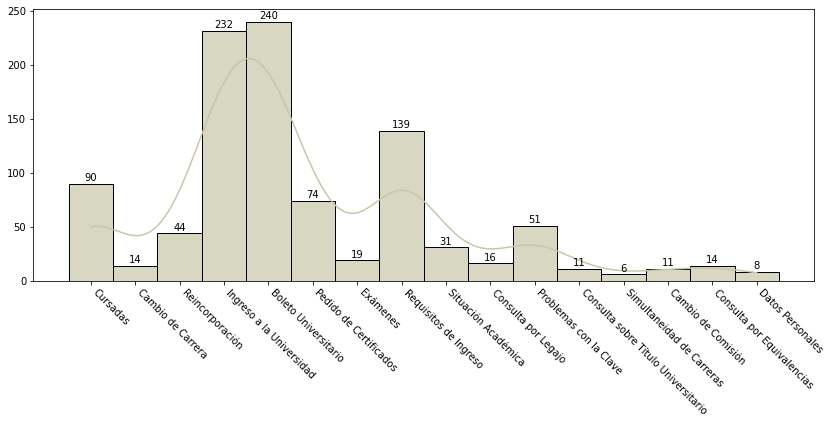

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def hist_clases(serie_clases, desc_plot, filename_plot):
  """
  Se plotean las clases en función de la distribución de la frecuencia
  observada en cada dataset
  """

  # Set figure size
  plt.figure(figsize=(14,5))

  ax = sns.histplot(serie_clases, kde=True, stat='count', 
                    bins=serie_clases.unique(), binwidth=0.06, 
                    color='#c8c6a7', alpha=0.7)

  ax.set_xticklabels(serie_clases.unique(),
                    rotation=-45, 
                    horizontalalignment='left', fontweight='light')

  for p in ax.patches:
      ax.annotate(f'{p.get_height():.0f}\n',
                  (p.get_x() + p.get_width() / 2, p.get_height()), 
                  ha='center', va='center', color='black')

  # Quito el nombre de los ejes (de forma rústica)
  plt.xlabel('', fontsize=12)
  plt.ylabel('', fontsize=12)

  # Guardo el plot en un png
  plt.savefig(filename_plot, optimize=True, transparent=True, bbox_inches = 'tight')

  # Muestro el gráfico con una descripción
  print(f'\t\t\tDistribución de clases para el {desc_plot}')
  plt.show()  

hist_clases(correos_etiquetados['clase'], 'Total dataset', 'histograma_total.png')

In [25]:
correos_etiquetados.shape

(1000, 24)

## 6. Train/Test dataset

Ahora, se splitean los datasets a en una proporción 80/20. Estos datasets se utilizarán para _feature extraction_ y para la generación de los modelos:

In [26]:
# Separo datos de entrenamiento y testing
from sklearn.model_selection import train_test_split

X = correos_etiquetados.drop(columns=['clase'])
y = correos_etiquetados['clase']

# Separo en 80-20 entrenamiento/validación y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

Ahora unificamos X e y para persistir los datasets:

In [27]:
# Reordeno el índice para poder concatenar con el y_train e y_test

# Train
X_train.reset_index(drop=True, inplace=True)
y_train_series = pd.Series(y_train)
df_train = X_train.merge(y_train_series.rename('clase'), left_index=True, right_index=True)

# Test
X_test.reset_index(drop=True, inplace=True)
y_test_series = pd.Series(y_test)
df_test = X_test.merge(y_test_series.rename('clase'), left_index=True, right_index=True)

Por último se persisten en _Drive_:

In [28]:
# Me autentico en Drive
from google.colab import drive

# Guardo en Drive los datos de entrenamiento
df_train.to_csv('correos-train-jaiio-80.csv', index=False)
drive.mount('drive')
!cp correos-train-jaiio-80.csv "drive/My Drive/"

# Guardo en Drive los datos de testeo
df_test.to_csv('correos-test-jaiio-20.csv', index=False)
drive.mount('drive')
!cp correos-test-jaiio-20.csv "drive/My Drive/"

Mounted at drive
Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains